# Assignment 2 #

We are given three columns of integers with a row for each node. The first two columns contain x and y coordinates of the node positions in a plane. The third column contains node costs. The goal is to select exactly 50% of the nodes (if the number of nodes is odd we round the number of nodes to be selected up) and form a Hamiltonian cycle (closed path) through this set of nodes such that the sum of the total length of the path plus the total cost of the selected nodes is minimized. The distances between nodes are calculated as Euclidean distances rounded mathematically to integer values. The distance matrix should be calculated just after reading an instance and then only the distance matrix (no nodes coordinates) should be accessed by optimization methods to allow instances defined only by distance matrices. 

## Read the data ##

In [1]:
import pandas as pd
import numpy as np
from numpy.typing import ArrayLike, NDArray
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from math import sqrt

In [2]:
# read data into dataframes
instances = {
    "A": pd.read_csv("data/TSPA.csv", sep=';', header=None, names=["x", "y", "cost"]),
    "B": pd.read_csv("data/TSPB.csv", sep=';', header=None, names=["x", "y", "cost"]),
    "C": pd.read_csv("data/TSPC.csv", sep=';', header=None, names=["x", "y", "cost"]),
    "D": pd.read_csv("data/TSPD.csv", sep=';', header=None, names=["x", "y", "cost"]),
}

In [3]:
def calculate_distance_matrix(df: pd.DataFrame) -> NDArray[np.int32]:
    """
    Calculate the distance matrix from the dataframe.
    The dataframe contains 'x' and 'y' columns for the coordinates.
    The distances are Euclidean, rounded to the nearest integer + the cost of the destination node.
    """
    coordinates = df[['x', 'y']].to_numpy()
    costs = df["cost"].to_numpy()
    dist_matrix = np.zeros(shape=(len(df), len(df)))
    for i in range(len(coordinates)):
        for j in range(len(coordinates)):
            dist_matrix[i, j] = round(sqrt((coordinates[i, 0] - coordinates[j, 0])**2 + (coordinates[i, 1] - coordinates[j, 1])**2)) + costs[j]
    return dist_matrix

In [4]:
distances_matrices = {
    "A": calculate_distance_matrix(instances["A"]),
    "B": calculate_distance_matrix(instances["B"]),
    "C": calculate_distance_matrix(instances["C"]),
    "D": calculate_distance_matrix(instances["D"])
}

costs = {
    "A": instances["A"]["cost"].to_numpy(),
    "B": instances["B"]["cost"].to_numpy(),
    "C": instances["C"]["cost"].to_numpy(),
    "D": instances["D"]["cost"].to_numpy()
}

In [5]:
def visualize_selected_route(
    selected_nodes_indices: ArrayLike, 
    dataframe: pd.DataFrame,
    title: str) -> None:
    """
    Visualize the selected route returned by the algorithm, including the cost of each node represented by a colormap.

    Parameters:
    selected_nodes_indices (list): Indices of the selected nodes in the route.
    dataframe (DataFrame): DataFrame containing 'x', 'y', and 'cost' columns for each node.
    """
    # x = dataframe.loc[selected_nodes_indices, 'x']
    # y = dataframe.loc[selected_nodes_indices, 'y']
    # costs = dataframe.loc[selected_nodes_indices, 'cost']
    x = dataframe["x"].to_numpy()
    y = dataframe["y"].to_numpy()
    costs = dataframe["cost"].to_numpy()

    cmap = plt.cm.get_cmap('viridis')
    norm = plt.Normalize(vmin=min(costs), vmax=max(costs))

    plt.figure(figsize=(15, 10))
    scatter = plt.scatter(x, y, c=costs, cmap=cmap, norm=norm, s=100)
    plt.colorbar(scatter, label='Node Cost')

    for i, node in enumerate(selected_nodes_indices):
        start_node = selected_nodes_indices[i]
        end_node = selected_nodes_indices[(i + 1) % len(selected_nodes_indices)]
        plt.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'k-', lw=1)

    plt.title(title, fontsize=18)
    plt.xlabel('X Coordinate', fontsize=14)
    plt.ylabel('Y Coordinate', fontsize=14)
    plt.grid(True)
    plt.show()

## Greedy 2-regret

In [6]:
def generate_greedy_regret(dist_matrix, start_node):
    num_nodes = dist_matrix.shape[0]
    num_select = (num_nodes + 1) // 2  # Selecting 50% of the nodes

    # Initialize the cycle with the start_node
    selected_nodes = [start_node]
    unselected_nodes = set(range(num_nodes)) - {start_node}

    # Initialize the total distance to 0
    total_distance = 0

    # Continue until we've selected the required number of nodes
    while len(selected_nodes) < num_select:
        regret_node = None
        regret_position = None
        best_regret= float('-inf')
        regret_best_increase = float('inf')
        # Evaluate the insertion of each unselected node
        for node in unselected_nodes:
            best_node = None
            best_position = None
            best_min_increase = float('inf')
            second_best_min_increase = float('inf')
            # Try inserting between each pair of consecutive nodes in the cycle
            for i in range(len(selected_nodes)):
                # Calculate the increase in distance
                next_i = (i + 1) % len(selected_nodes)
                increase = (dist_matrix[selected_nodes[i], node] +
                            dist_matrix[node, selected_nodes[next_i]] -
                            dist_matrix[selected_nodes[i], selected_nodes[next_i]])
                
                # Check if it is the best position
                if increase < second_best_min_increase: 
                    if increase < best_min_increase:
                        best_min_increase = increase
                        best_node = node
                        best_position = next_i  # Insert before next_i
                    #or the second best position
                    else: 
                        second_best_min_increase = increase
            #for a given unselected node after checking all of the positions and finding two best increases, we calculate regret
            regret= second_best_min_increase - best_min_increase
            # for keeping track of the best regret so far and best corresponding node, position and increase
            if regret > best_regret:
                best_regret = regret
                regret_node =  best_node
                regret_position = best_position 
                regret_best_increase = best_min_increase
                    

        # Insert the best node into the cycle
        selected_nodes.insert(regret_position, regret_node)
        unselected_nodes.remove(regret_node)
        total_distance += regret_best_increase
        

    # Complete the cycle
    total_distance += dist_matrix[selected_nodes[-1], selected_nodes[0]]

    return selected_nodes, total_distance

In [7]:
num_solutions = 200
regret_solutions = {
    "A": [generate_greedy_regret(distances_matrices["A"], start_node=start_node) for start_node in tqdm(range(num_solutions))],
    "B": [generate_greedy_regret(distances_matrices["B"], start_node=start_node) for start_node in tqdm(range(num_solutions))],
    "C": [generate_greedy_regret(distances_matrices["C"], start_node=start_node) for start_node in tqdm(range(num_solutions))],
    "D": [generate_greedy_regret(distances_matrices["D"], start_node=start_node) for start_node in tqdm(range(num_solutions))]
}

regret_objectives_values = {
    "A": [solution[1] for solution in regret_solutions["A"]],
    "B": [solution[1] for solution in regret_solutions["B"]],
    "C": [solution[1] for solution in regret_solutions["C"]],
    "D": [solution[1] for solution in regret_solutions["D"]]
}

regret_selected_nodes = {
    "A": [solution[0] for solution in regret_solutions["A"]],
    "B": [solution[0] for solution in regret_solutions["B"]],
    "C": [solution[0] for solution in regret_solutions["C"]],
    "D": [solution[0] for solution in regret_solutions["D"]]
}

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [04:25<00:00,  1.33s/it]


In [8]:
for instance in regret_objectives_values:
    print(f"Instance {instance} - min: {min(regret_objectives_values[instance])}, max: {max(regret_objectives_values[instance])}, mean: {np.mean(regret_objectives_values[instance])}")

Instance A - min: 106734.0, max: 124404.0, mean: 116772.94
Instance B - min: 104997.0, max: 125925.0, mean: 116871.655
Instance C - min: 63247.0, max: 72558.0, mean: 68444.895
Instance D - min: 62852.0, max: 74184.0, mean: 68585.675


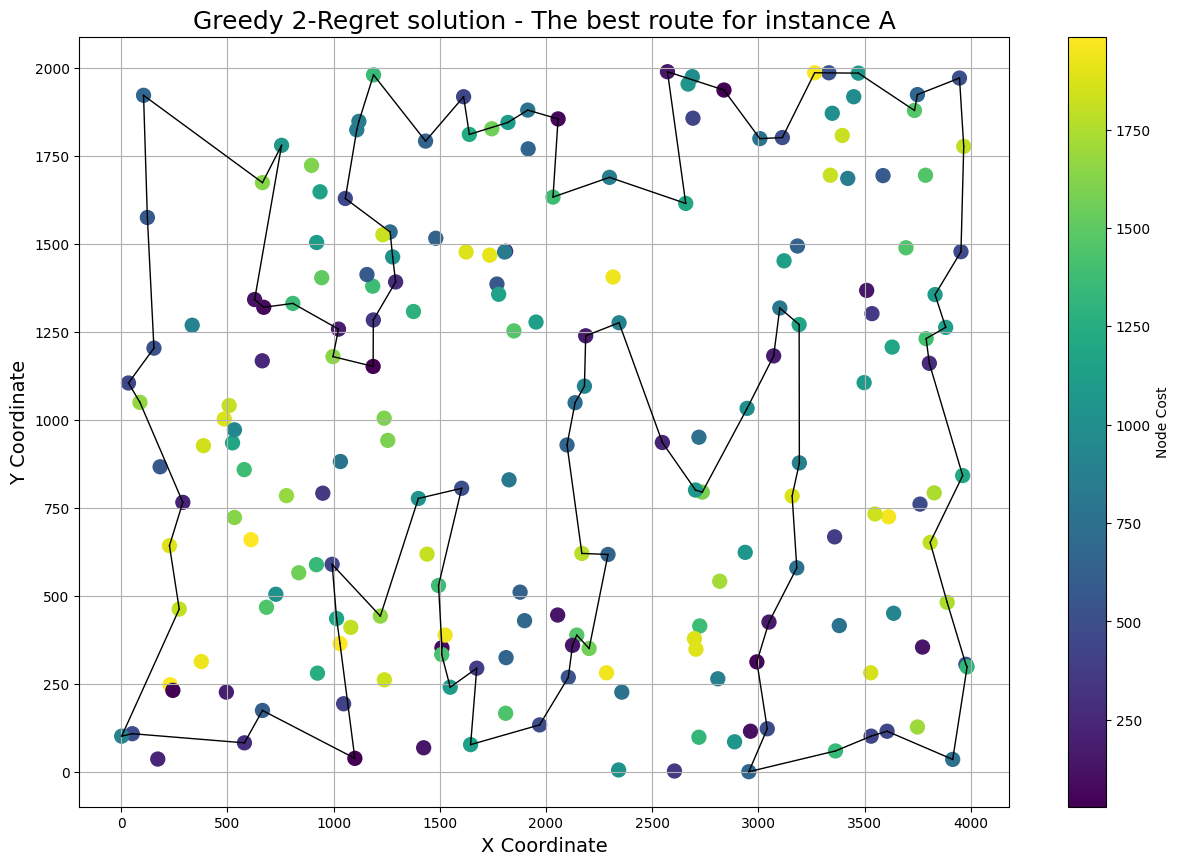

In [9]:
regret_best_A_solution = regret_solutions["A"][np.argmin(regret_objectives_values["A"])]
visualize_selected_route(regret_best_A_solution[0], instances["A"], "Greedy 2-Regret solution - The best route for instance A")

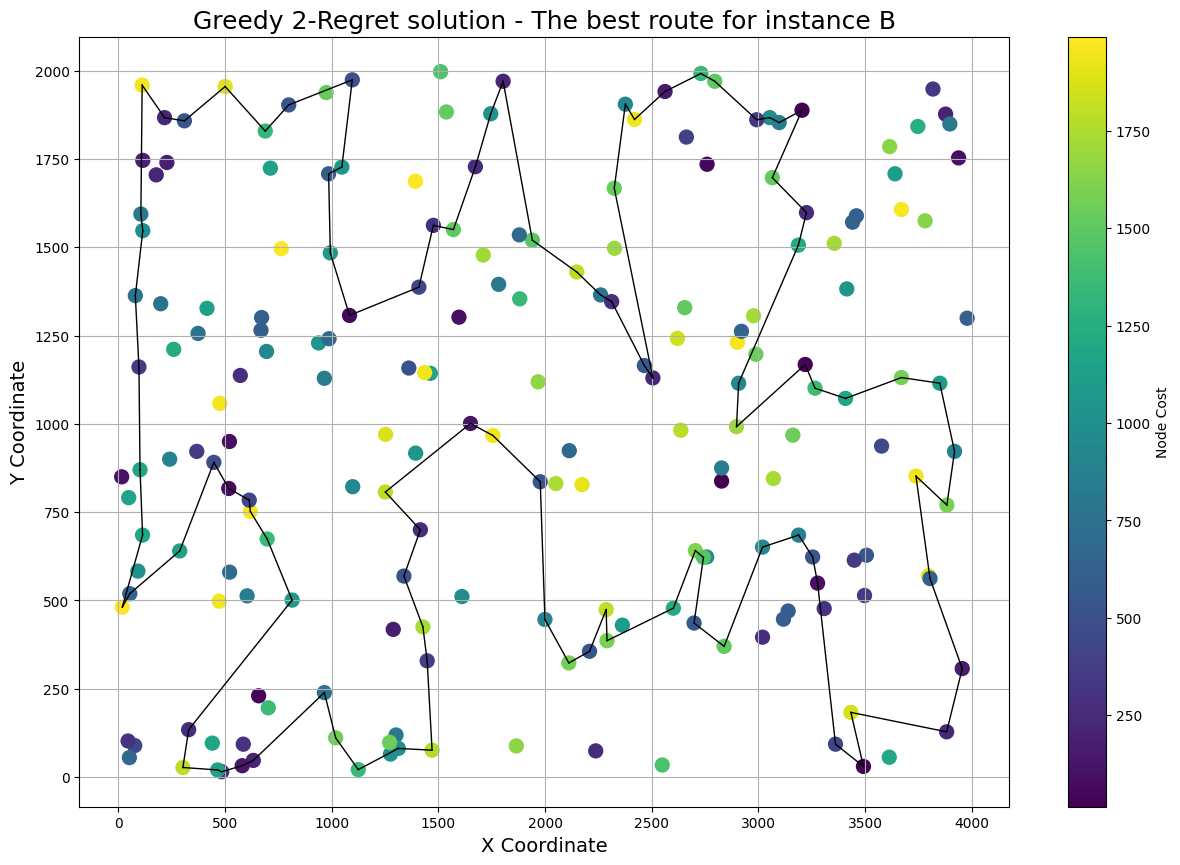

In [10]:
regret_best_B_solution = regret_solutions["B"][np.argmin(regret_objectives_values["A"])]
visualize_selected_route(regret_best_B_solution[0], instances["B"], "Greedy 2-Regret solution - The best route for instance B")

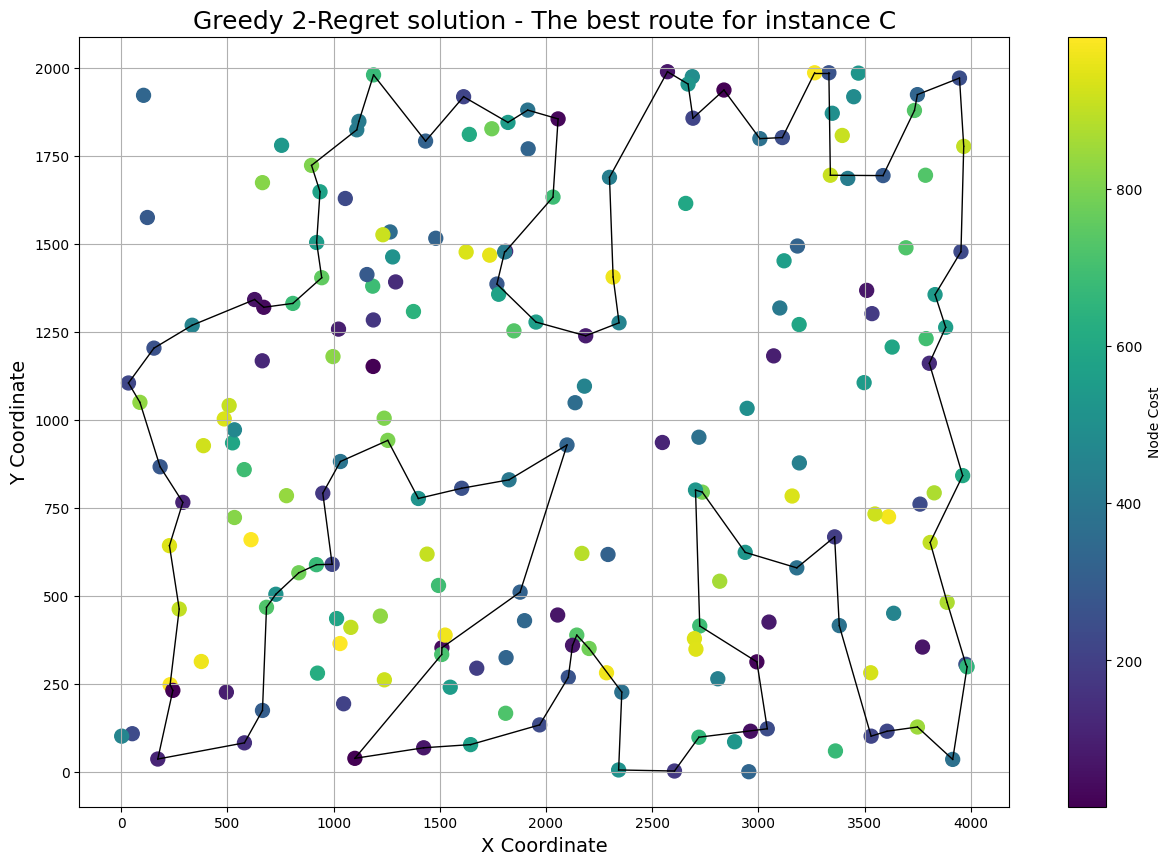

In [11]:
regret_best_C_solution = regret_solutions["C"][np.argmin(regret_objectives_values["C"])]
visualize_selected_route(regret_best_C_solution[0], instances["C"], "Greedy 2-Regret solution - The best route for instance C")

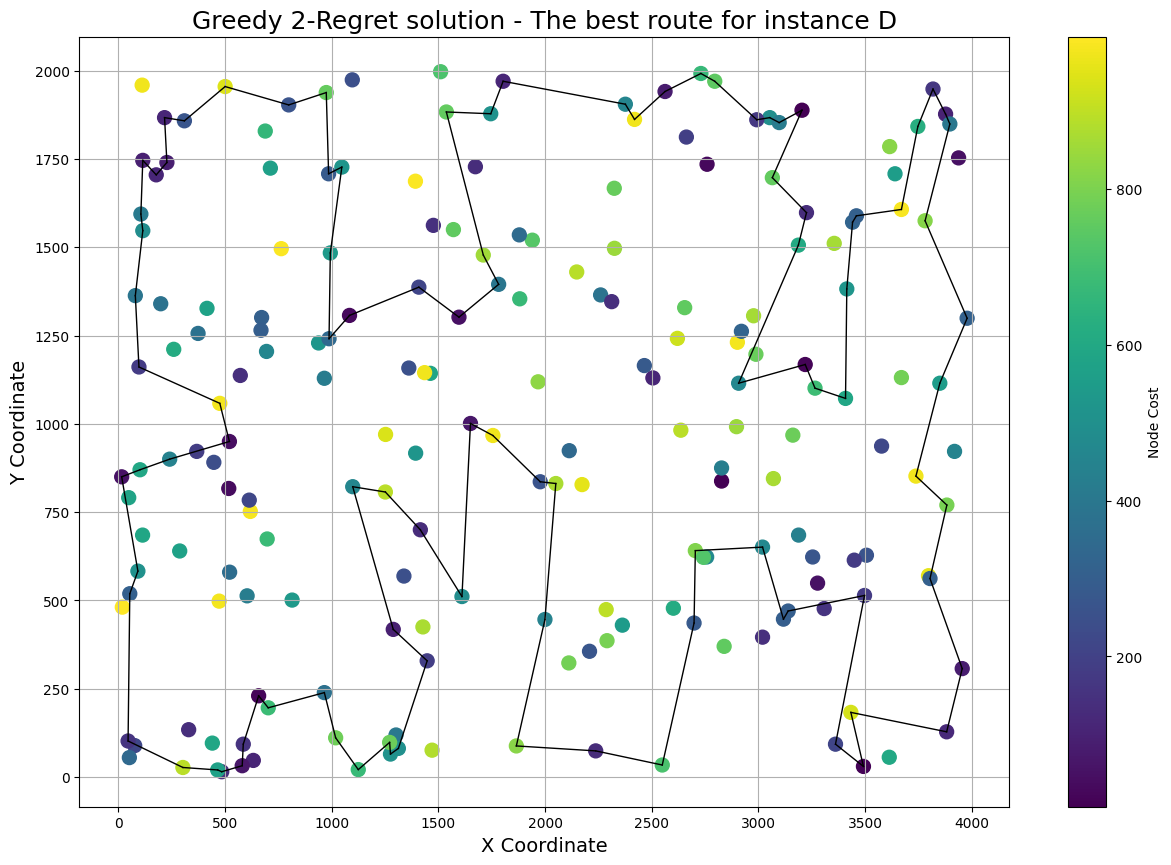

In [12]:
regret_best_D_solution = regret_solutions["D"][np.argmin(regret_objectives_values["D"])]
visualize_selected_route(regret_best_D_solution[0], instances["D"], "Greedy 2-Regret solution - The best route for instance D")

In [13]:
def generate_greedy_weight_regret(dist_matrix, start_node, a):
    num_nodes = dist_matrix.shape[0]
    num_select = (num_nodes + 1) // 2  # Selecting 50% of the nodes

    # Initialize the cycle with the start_node
    selected_nodes = [start_node]
    unselected_nodes = set(range(num_nodes)) - {start_node}

    # Initialize the total distance to 0
    total_distance = 0

    # Continue until we've selected the required number of nodes
    while len(selected_nodes) < num_select:
        score_node = None
        score_position = None
        best_score= float('-inf')
        score_best_increase = float('inf')
        # Evaluate the insertion of each unselected node
        for node in unselected_nodes:
            best_node = None
            best_position = None
            best_min_increase = float('inf')
            second_best_min_increase = float('inf')
            # Try inserting between each pair of consecutive nodes in the cycle
            for i in range(len(selected_nodes)):
                # Calculate the increase in distance
                next_i = (i + 1) % len(selected_nodes)
                increase = (dist_matrix[selected_nodes[i], node] +
                            dist_matrix[node, selected_nodes[next_i]] -
                            dist_matrix[selected_nodes[i], selected_nodes[next_i]])
                
                # Check if it is the best position
                if increase < second_best_min_increase: 
                    if increase < best_min_increase:
                        best_min_increase = increase
                        best_node = node
                        best_position = next_i  # Insert before next_i
                    #or the second best position
                    else: 
                        second_best_min_increase = increase
            #for a given unselected node after checking all of the positions and finding two best increases, we calculate regret
            regret= second_best_min_increase - best_min_increase
            score = a * regret - (1-a)*best_min_increase
            # for keeping track of the best regret so far and best corresponding node, position and increase
            if score > best_score:
                best_score = score
                score_node =  best_node
                score_position = best_position 
                score_best_increase = best_min_increase
                    

        # Insert the best node into the cycle
        selected_nodes.insert(score_position, score_node)
        unselected_nodes.remove(score_node)
        total_distance += score_best_increase
        

    # Complete the cycle
    total_distance += dist_matrix[selected_nodes[-1], selected_nodes[0]]

    return selected_nodes, total_distance

In [14]:
num_solutions = 200
a= 0.5
weight_regret_solutions = {
    "A": [generate_greedy_weight_regret(distances_matrices["A"], start_node=start_node,a=a) for start_node in tqdm(range(num_solutions))],
    "B": [generate_greedy_weight_regret(distances_matrices["B"], start_node=start_node,a=a) for start_node in tqdm(range(num_solutions))],
    "C": [generate_greedy_weight_regret(distances_matrices["C"], start_node=start_node,a=a) for start_node in tqdm(range(num_solutions))],
    "D": [generate_greedy_weight_regret(distances_matrices["D"], start_node=start_node,a=a) for start_node in tqdm(range(num_solutions))]
}

weight_regret_objectives_values = {
    "A": [solution[1] for solution in weight_regret_solutions["A"]],
    "B": [solution[1] for solution in weight_regret_solutions["B"]],
    "C": [solution[1] for solution in weight_regret_solutions["C"]],
    "D": [solution[1] for solution in weight_regret_solutions["D"]]
}

weight_regret_selected_nodes = {
    "A": [solution[0] for solution in weight_regret_solutions["A"]],
    "B": [solution[0] for solution in weight_regret_solutions["B"]],
    "C": [solution[0] for solution in weight_regret_solutions["C"]],
    "D": [solution[0] for solution in weight_regret_solutions["D"]]
}

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [01:30<00:00,  2.21it/s]


In [15]:
for instance in weight_regret_objectives_values:
    print(f"Instance {instance} - min: {min(weight_regret_objectives_values[instance])}, max: {max(weight_regret_objectives_values[instance])}, mean: {np.mean(weight_regret_objectives_values[instance])}")

Instance A - min: 74708.0, max: 82990.0, mean: 76980.75
Instance B - min: 67490.0, max: 80001.0, mean: 73067.755
Instance C - min: 50158.0, max: 58173.0, mean: 53795.98
Instance D - min: 46549.0, max: 62321.0, mean: 52930.7


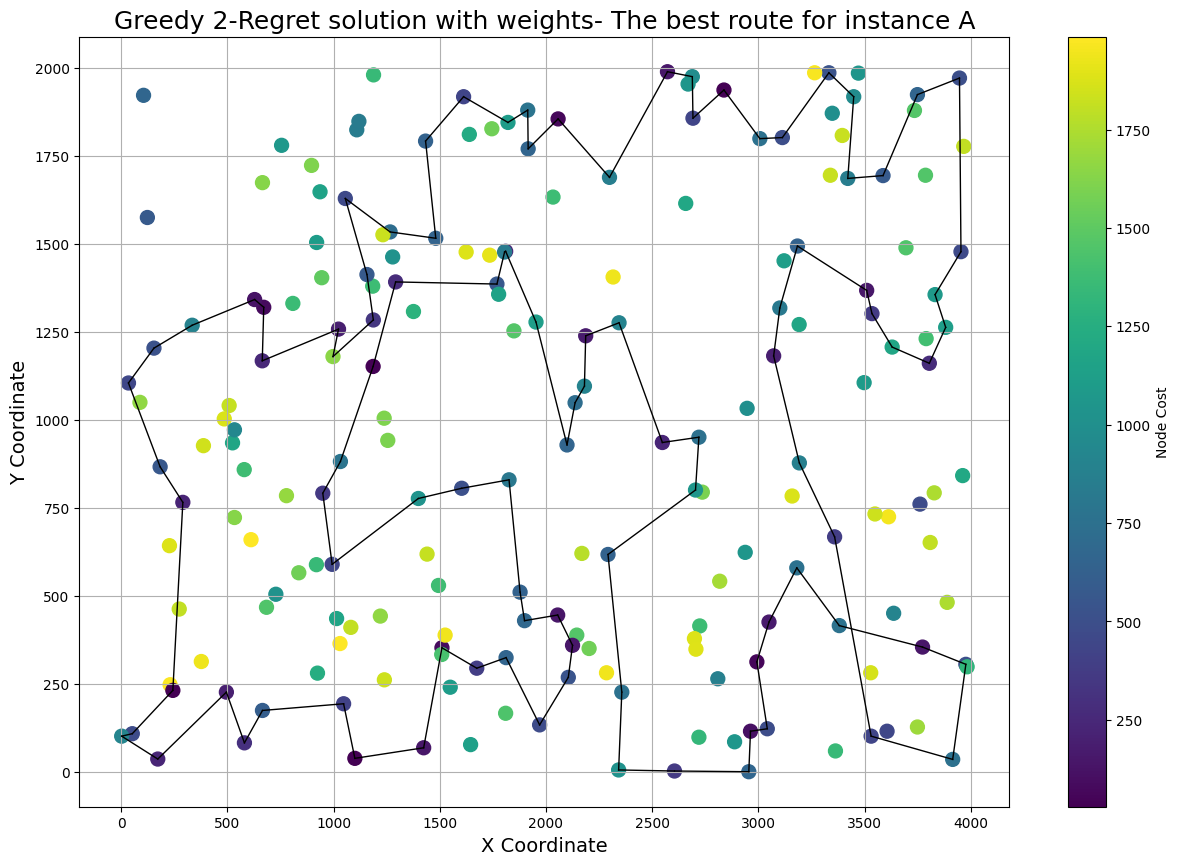

In [16]:
weight_regret_best_A_solution = weight_regret_solutions["A"][np.argmin(weight_regret_objectives_values["A"])]
visualize_selected_route(weight_regret_best_A_solution[0], instances["A"], "Greedy 2-Regret solution with weights- The best route for instance A")

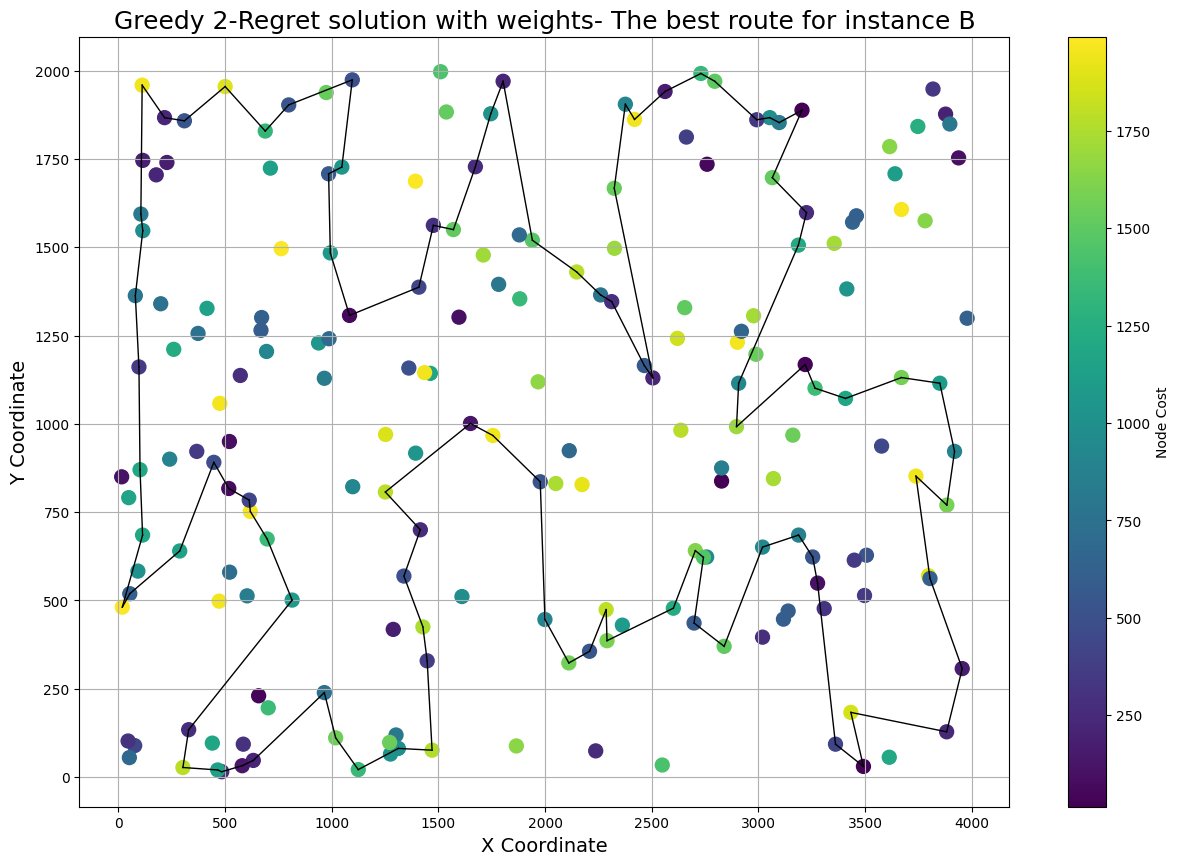

In [17]:
weight_regret_best_B_solution = weight_regret_solutions["B"][np.argmin(weight_regret_objectives_values["A"])]
visualize_selected_route(regret_best_B_solution[0], instances["B"], "Greedy 2-Regret solution with weights- The best route for instance B")

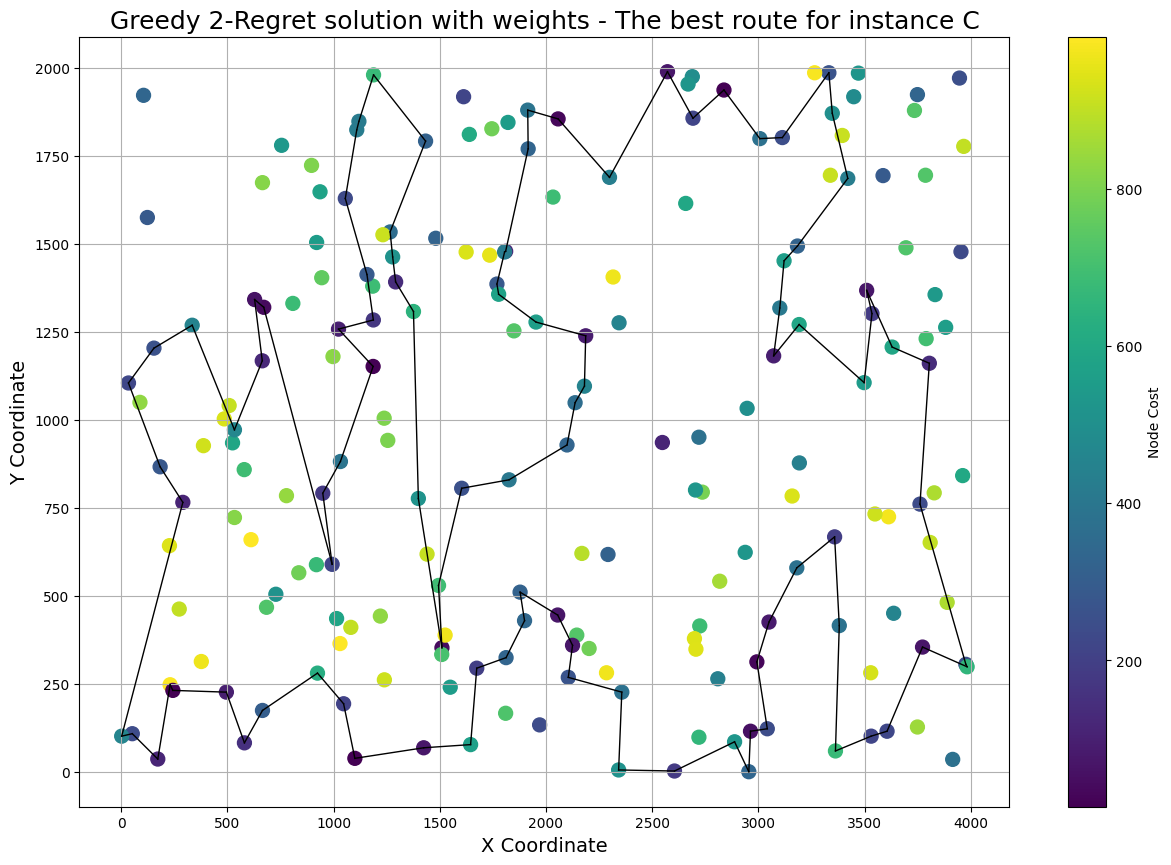

In [18]:
weight_regret_best_C_solution = weight_regret_solutions["C"][np.argmin(weight_regret_objectives_values["C"])]
visualize_selected_route(weight_regret_best_C_solution[0], instances["C"], "Greedy 2-Regret solution with weights - The best route for instance C")

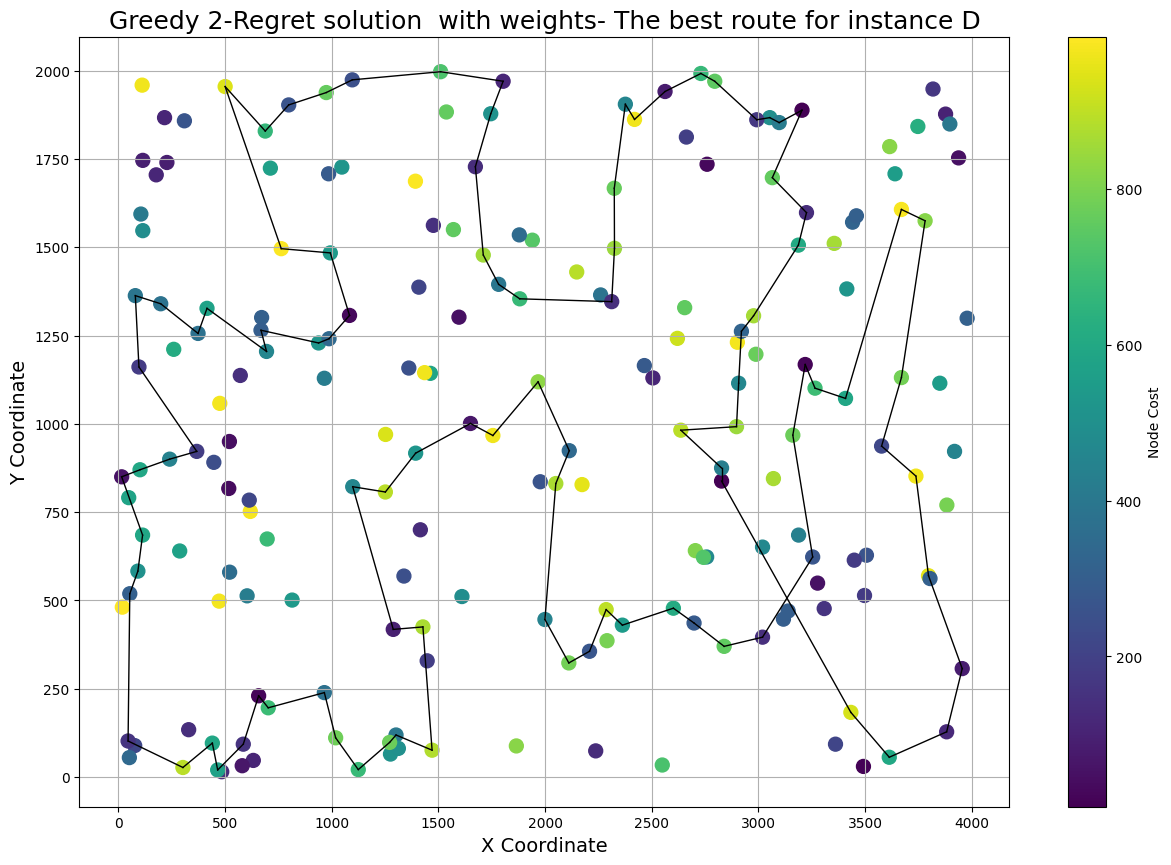

In [19]:
weight_regret_best_D_solution = regret_solutions["D"][np.argmin(weight_regret_objectives_values["D"])]
visualize_selected_route(weight_regret_best_D_solution[0], instances["D"], "Greedy 2-Regret solution  with weights- The best route for instance D")